In [64]:
import pandas as pd #데이터 분석/처리 (csv 파일을 읽기 위함)
import numpy as np #행렬 연산                     -> pandas/numpy 보통 함께 쓰인다.
import matplotlib.pyplot as plt #데이터 시각화
#keras -> 딥러닝 모델 작성
from keras.models import Sequential #Sequential 모델사용
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

Load Dataset

In [65]:
data = pd.read_csv('KAKAO.KS_5y.csv') #네이버 5년 주식데이터(csv파일 로드 후, data변수에 넣기)
data.head() #맨앞 5줄로 데이터 출력

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-10,118300,119600,115100,116000,115459.8828,639825
1,2015-06-11,117700,118500,114500,114500,113966.8750,464246
2,2015-06-12,113800,114700,109800,110800,110284.0938,669117
3,2015-06-15,109200,110500,105000,105600,105108.3125,639238
4,2015-06-16,105000,109600,99800,101700,101226.4688,1319340


Compute Mid Price

In [66]:
high_prices = data['High'].values #최상값
low_prices = data['Low'].values #최하값
mid_prices = (high_prices + low_prices) / 2  #중간값 

Create Windows

In [67]:
seq_len = 50 #50일 데이터를 보고 다음날 값 예측 (LSTM 개념)
sequence_length = seq_len + 1 #예측값에서 +1을 함

result = [] # 리스트에 51개씩 값을 저장
for index in range(len(mid_prices) - sequence_length):
  result.append(mid_prices[index: index + sequence_length])

Normalize Data

In [68]:
normalized_data = [] #데이터 정규화 리스트
for window in result: #데이터 정규화
  normalized_window = [((float(p) / float(window[0])) -1 ) for p in window]
  normalized_data.append(normalized_window)

result = np.array(normalized_data)

# 전체 데이터를 트레인 데이터와 테스트 데이터로 나눔.
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]#train셋에 전체데이터 90%
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:, -1]

x_test = result[row:, :-1] #test셋에 전체데이터 10%
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1055, 50, 1), (117, 50, 1))

Build a Model

In [69]:
model = Sequential() #모델 순차적 정의

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear')) #다음날 하루의 데이터를 예측

model.compile(loss='mse', optimizer='rmsprop') # ms(손실함수) - > mean squared error

model.summary() #모델의 개요를 출력

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


Training

In [70]:
# .fit -> 학습을 시킨다.
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=10, epochs=20) #10개씩 묶어서 학습을 20번 반복 학습.

Epoch 1/20
106/106 [==============================] - 5s 49ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 2/20
106/106 [==============================] - 4s 42ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 3/20
106/106 [==============================] - 4s 41ms/step - loss: 8.2197e-04 - val_loss: 0.0023
Epoch 4/20
106/106 [==============================] - 4s 40ms/step - loss: 6.3602e-04 - val_loss: 0.0011
Epoch 5/20
106/106 [==============================] - 4s 40ms/step - loss: 5.1297e-04 - val_loss: 0.0012
Epoch 6/20
106/106 [==============================] - 4s 40ms/step - loss: 4.5230e-04 - val_loss: 7.7377e-04
Epoch 7/20
106/106 [==============================] - 4s 40ms/step - loss: 4.1749e-04 - val_loss: 8.5034e-04
Epoch 8/20
106/106 [==============================] - 4s 40ms/step - loss: 4.0689e-04 - val_loss: 7.3146e-04
Epoch 9/20
106/106 [==============================] - 4s 41ms/step - loss: 4.0015e-04 - val_loss: 6.9734e-04
Epoch 10/20
106/106 [==========================

Prediction

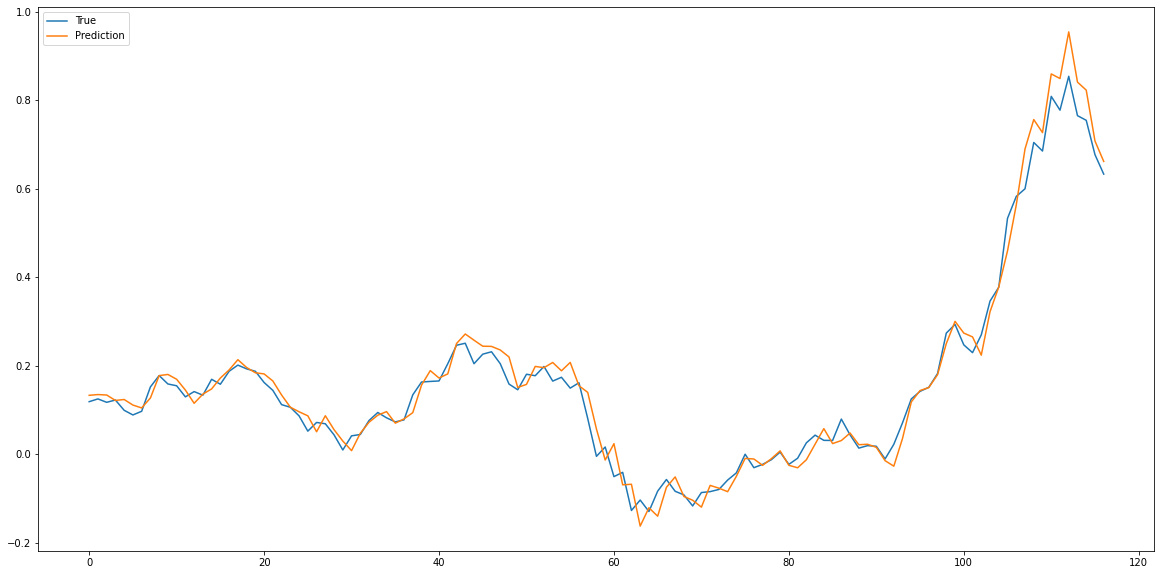

In [71]:
pred = model.predict(x_test) #모델을 사용하여 예측

fig = plt.figure(facecolor='white', figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True') #실제데이터
ax.plot(pred, label='Prediction') #예측데이터
ax.legend()
plt.show()